<a href="https://colab.research.google.com/github/ismailkaya83/MY-DEEP-LEARNING-NOTEBOOKS/blob/master/Classifying_newswires_a_multiclass_classification_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Classifying newswires: a multiclass classification example**

In this section, you’ll build a model to classify Reuters newswires into 46 mutually exclusive topics. Because you have many classes, this problem is an instance of multiclass classification; and because each data point should be classified into only one category, the problem is more specifically an instance of single-label, multiclass classification. If each data point could belong to multiple categories (in this case, topics), you’d be facing a multilabel, multiclass classification problem.

## **The Reuters dataset**

You’ll work with the Reuters dataset, a set of short newswires and their topics, published by Reuters in 1986. It’s a simple, widely used toy dataset for text classification. There are 46 different topics; some topics are more represented than others, but each topic has at least 10 examples in the training set.

In [1]:
"Loading the Reuters dataset"

from tensorflow.keras.datasets import reuters
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)
# the argument num_words=10000 restricts the data to the 10,000 most frequently occurring words found in the data.

2113536/2110848 [==============================] - 0s 0us/step


In [2]:
"You have 8,982 training examples and 2,246 test examples:"

len(train_data), len(test_data)

(8982, 2246)

In [ ]:
"each example is a list of integers (word indices):"

train_data[10]

In [5]:
"Here’s how you can decode it back to words, in case you’re curious."

word_index = reuters.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
decoded_newswire = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]])

557056/550378 [==============================] - 0s 0us/step


In [6]:
"The label associated with an example is an integer between 0 and 45 — a topic index:"

train_labels[10]

3

## **Preparing the data**

You can vectorize the data with the exact same code as in the previous example.



In [8]:
"Encoding the input data"

import numpy as np

def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

To vectorize the labels, there are two possibilities: you can cast the label list as an integer tensor, or you can use one-hot encoding. One-hot encoding is a widely used format for categorical data, also called categorical encoding. For a more detailed explanation of one-hot encoding, see section TODO. In this case, one-hot encoding of the labels consists of embedding each label as an all-zero vector with a 1 in the place of the label index. Here’s an example:

In [9]:
"Encoding the labels"

def to_one_hot(labels, dimension=46):
    results = np.zeros((len(labels), dimension))
    for i, label in enumerate(labels):
        results[i, label] = 1.
    return results
one_hot_train_labels = to_one_hot(train_labels)
one_hot_test_labels = to_one_hot(test_labels)

In [10]:
"Note that there is a built-in way to do this in Keras:"

from tensorflow.keras.utils import to_categorical
one_hot_train_labels = to_categorical(train_labels)
one_hot_test_labels = to_categorical(test_labels)

## **Building your model**

This topic-classification problem looks similar to the previous movie-review classification problem: in both cases, you’re trying to classify short snippets of text. But there is a new constraint here: the number of output classes has gone from 2 to 46. The dimensionality of the output space is much larger.

In a stack of Dense layers like that you’ve been using, each layer can only access information present in the output of the previous layer. If one layer drops some information relevant to the classification problem, this information can never be recovered by later layers: each layer can potentially become an information bottleneck. In the previous example, you used 16-dimensional intermediate layers, but a 16-dimensional space may be too limited to learn to separate 46 different classes: such small layers may act as information bottlenecks, permanently dropping relevant information.

For this reason you’ll use larger layers. Let’s go with 64 units.

In [13]:
"Model definition"

from tensorflow import keras
from tensorflow.keras import layers
model = keras.Sequential([
  layers.Dense(64, activation='relu'),
  layers.Dense(64, activation='relu'),
  layers.Dense(46, activation='softmax')
])

There are two other things you should note about this architecture:

You end the model with a Dense layer of size 46. This means for each input sample, the network will output a 46-dimensional vector. Each entry in this vector (each dimension) will encode a different output class.

The last layer uses a softmax activation. You saw this pattern in the MNIST example. It means the model will output a probability distribution over the 46 different output classes — for every input sample, the model will produce a 46-dimensional output vector, where output[i] is the probability that the sample belongs to class i. The 46 scores will sum to 1.

The best loss function to use in this case is categorical_crossentropy. It measures the distance between two probability distributions: here, between the probability distribution output by the model and the true distribution of the labels. By minimizing the distance between these two distributions, you train the model to output something as close as possible to the true labels.

In [14]:
"Compiling the model"

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## **Validating your approach**

Let’s set apart 1,000 samples in the training data to use as a validation set.

In [15]:
"Setting aside a validation set"

x_val = x_train[:1000]
partial_x_train = x_train[1000:]
y_val = one_hot_train_labels[:1000]
partial_y_train = one_hot_train_labels[1000:]

In [16]:
"Training the model"

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Epoch 1/20
16/16 [==============================] - 0s 23ms/step - loss: 2.6347 - accuracy: 0.5109 - val_loss: 1.7512 - val_accuracy: 0.6230
Epoch 2/20
16/16 [==============================] - 0s 14ms/step - loss: 1.4387 - accuracy: 0.7017 - val_loss: 1.3103 - val_accuracy: 0.7080
Epoch 3/20
16/16 [==============================] - 0s 14ms/step - loss: 1.0587 - accuracy: 0.7701 - val_loss: 1.1291 - val_accuracy: 0.7680
Epoch 4/20
16/16 [==============================] - 0s 13ms/step - loss: 0.8275 - accuracy: 0.8286 - val_loss: 1.0283 - val_accuracy: 0.7830
Epoch 5/20
16/16 [==============================] - 0s 14ms/step - loss: 0.6554 - accuracy: 0.8639 - val_loss: 0.9559 - val_accuracy: 0.8030
Epoch 6/20
16/16 [==============================] - 0s 14ms/step - loss: 0.5283 - accuracy: 0.8891 - val_loss: 0.9281 - val_accuracy: 0.8000
Epoch 7/20
16/16 [==============================] - 0s 14ms/step - loss: 0.4297 - accuracy: 0.9122 - val_loss: 0.8973 - val_accuracy: 0.8060
Epoch 8/20
16

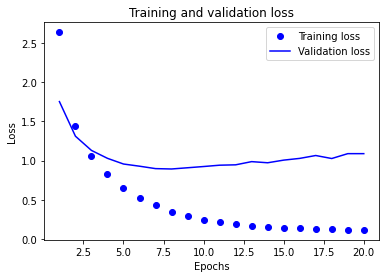

In [18]:
"Plotting the training and validation loss"

import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

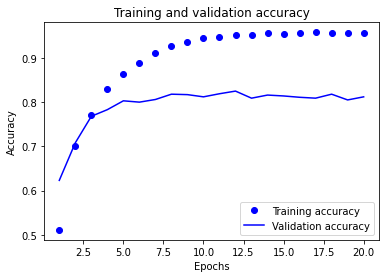

In [19]:
"Plotting the training and validation accuracy"

plt.clf()
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

The model begins to overfit after nine epochs. Let’s train a new model from scratch for nine epochs and then evaluate it on the test set.



In [20]:
"Retraining a model from scratch"

model = keras.Sequential([
  layers.Dense(64, activation='relu'),
  layers.Dense(64, activation='relu'),
  layers.Dense(46, activation='softmax')
])
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(partial_x_train,
          partial_y_train,
          epochs=9,
          batch_size=512,
          validation_data=(x_val, y_val))
results = model.evaluate(x_test, one_hot_test_labels)

Epoch 1/9
16/16 [==============================] - 0s 23ms/step - loss: 2.7917 - accuracy: 0.5598 - val_loss: 1.8423 - val_accuracy: 0.6430
Epoch 2/9
16/16 [==============================] - 0s 14ms/step - loss: 1.4641 - accuracy: 0.7146 - val_loss: 1.3095 - val_accuracy: 0.7320
Epoch 3/9
16/16 [==============================] - 0s 14ms/step - loss: 1.0654 - accuracy: 0.7755 - val_loss: 1.1443 - val_accuracy: 0.7490
Epoch 4/9
16/16 [==============================] - 0s 14ms/step - loss: 0.8383 - accuracy: 0.8192 - val_loss: 1.0431 - val_accuracy: 0.7760
Epoch 5/9
16/16 [==============================] - 0s 14ms/step - loss: 0.6718 - accuracy: 0.8572 - val_loss: 0.9788 - val_accuracy: 0.7890
Epoch 6/9
16/16 [==============================] - 0s 14ms/step - loss: 0.5360 - accuracy: 0.8931 - val_loss: 0.9324 - val_accuracy: 0.8050
Epoch 7/9
16/16 [==============================] - 0s 14ms/step - loss: 0.4359 - accuracy: 0.9105 - val_loss: 0.9021 - val_accuracy: 0.8110
Epoch 8/9
16/16 [===

In [21]:
results

[0.9713983535766602, 0.7911843061447144]

This approach reaches an accuracy of ~80%. With a balanced binary classification problem, the accuracy reached by a purely random classifier would be 50%. But in this case, we have 46 classes, and they may not be equally represented. What would be the accuracy of a random baseline? We could try quickly implementing one to check this empirically:

In [22]:
import copy
test_labels_copy = copy.copy(test_labels)
np.random.shuffle(test_labels_copy)
hits_array = np.array(test_labels) == np.array(test_labels_copy)
float(np.sum(hits_array)) / len(test_labels)

0.1803205699020481

As you can see, a random classifier would score around 19% classification accuracy, so the results of our model seem pretty good in that light.



## **Generating predictions on new data**

Calling the model’s predict method on new samples returns a class probability distribution over all 46 topics for each sample. Let’s generate topic predictions for all of the test data.



In [23]:
predictions = model.predict(x_test)

Each entry in “predictions` is a vector of length 46:



In [24]:
predictions[0].shape

(46,)

The coefficients in this vector sum to 1, as they form a probability distribution:



In [25]:
np.sum(predictions[0])

1.0

The largest entry is the predicted class — the class with the highest probability:



In [26]:
np.argmax(predictions[0])

3

## **A different way to handle the labels and the loss**

We mentioned earlier that another way to encode the labels would be to cast them as an integer tensor, like this:



In [27]:
y_train = np.array(train_labels)
y_test = np.array(test_labels)

The only thing this approach would change is the choice of the loss function. The loss function used in listing 3.21, categorical_crossentropy, expects the labels to follow a categorical encoding. With integer labels, you should use sparse_categorical_crossentropy:



In [28]:
model.compile(optimizer='rmsprop',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

This new loss function is still mathematically the same as categorical_crossentropy; it just has a different interface.



## **The importance of having sufficiently large intermediate layers**

We mentioned earlier that because the final outputs are 46-dimensional, you should avoid intermediate layers with many fewer than 46 units. Now let’s see what happens when you introduce an information bottleneck by having intermediate layers that are significantly less than 46-dimensional: for example, 4-dimensional.



In [29]:
"A model with an information bottleneck"

model = keras.Sequential([
  layers.Dense(64, activation='relu'),
  layers.Dense(4, activation='relu'),
  layers.Dense(46, activation='softmax')
])
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(partial_x_train,
          partial_y_train,
          epochs=20,
          batch_size=128,
          validation_data=(x_val, y_val))

Epoch 1/20
63/63 [==============================] - 0s 8ms/step - loss: 3.6451 - accuracy: 0.0401 - val_loss: 3.4313 - val_accuracy: 0.0400
Epoch 2/20
63/63 [==============================] - 0s 6ms/step - loss: 3.1248 - accuracy: 0.0786 - val_loss: 2.8883 - val_accuracy: 0.0780
Epoch 3/20
63/63 [==============================] - 0s 6ms/step - loss: 2.2963 - accuracy: 0.3276 - val_loss: 1.9397 - val_accuracy: 0.6020
Epoch 4/20
63/63 [==============================] - 0s 6ms/step - loss: 1.4367 - accuracy: 0.6745 - val_loss: 1.4492 - val_accuracy: 0.6810
Epoch 5/20
63/63 [==============================] - 0s 5ms/step - loss: 1.1054 - accuracy: 0.7498 - val_loss: 1.3284 - val_accuracy: 0.7130
Epoch 6/20
63/63 [==============================] - 0s 6ms/step - loss: 0.9594 - accuracy: 0.7676 - val_loss: 1.2871 - val_accuracy: 0.7240
Epoch 7/20
63/63 [==============================] - 0s 6ms/step - loss: 0.8638 - accuracy: 0.7884 - val_loss: 1.2934 - val_accuracy: 0.7250
Epoch 8/20
63/63 [==

The model now peaks at ~71% validation accuracy, an 8% absolute drop. This drop is mostly due to the fact that you’re trying to compress a lot of information (enough information to recover the separation hyperplanes of 46 classes) into an intermediate space that is too low-dimensional. The model is able to cram most of the necessary information into these four-dimensional representations, but not all of it.

## **Wrapping up**

- If you’re trying to classify data points among N classes, your model should end with a Dense layer of size N.
- In a single-label, multiclass classification problem, your model should end with a softmax activation so that it will output a probability distribution over the N output classes.
- Categorical crossentropy is almost always the loss function you should use for such problems. It minimizes the distance between the probability distributions output by the model and the true distribution of the targets.
- There are two ways to handle labels in multiclass classification:

  - Encoding the labels via categorical encoding (also known as one-hot encoding) and using categorical_crossentropy as a loss function
  - Encoding the labels as integers and using the sparse_categorical_-crossentropy loss function
- If you need to classify data into a large number of categories, you should avoid creating information bottlenecks in your model due to intermediate layers that are too small.